# Shell element Response

Supported shell elements include most shell elements in OpenSees, including:

- ✅ ShellMITC4
- ✅ ShellMITC9
- ✅ ShellDKGQ
- ✅ ShellDKGT
- ✅ ShellNLDKGQ
- ✅ ShellNLDKGT
- ✅ ShellNL
- ✅ ASDShellQ4
- ✅ ASDShellT3

In [1]:
import matplotlib.pyplot as plt
import openseespy.opensees as ops

import opstool as opst

The original Tcl file comes from http://www.dinochen.com/, and the Python version is converted by opstool.tcl2py().


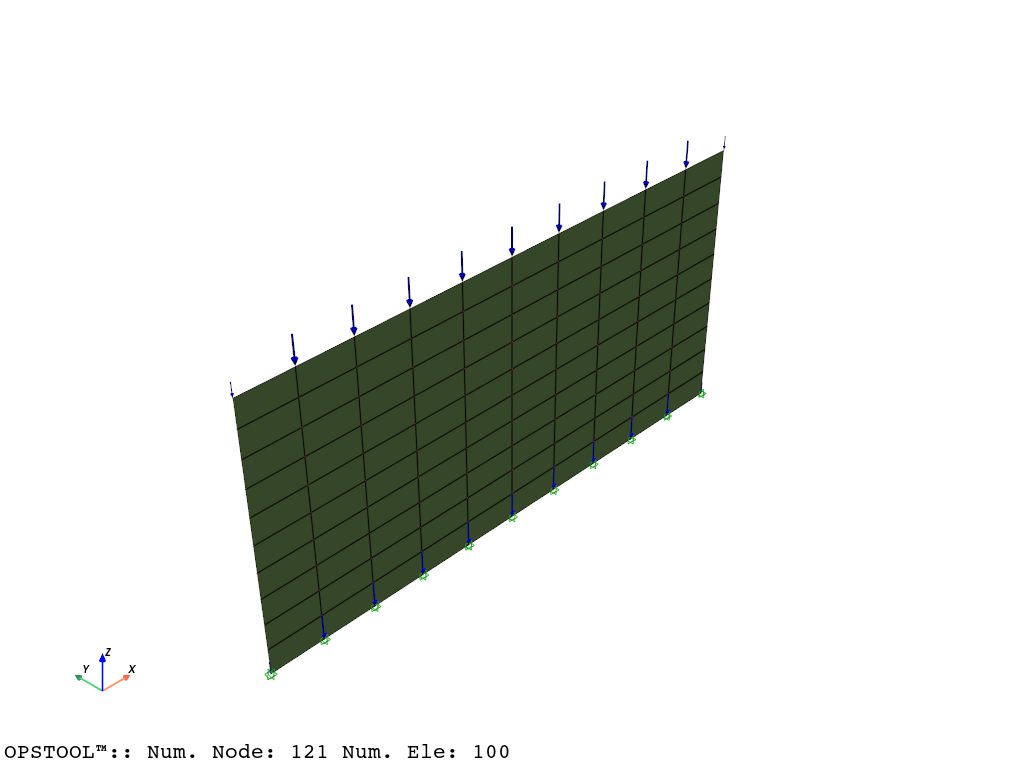

In [2]:
opst.load_ops_examples("Shell3D")  # or your model code here

# add beam loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
_ = opst.pre.gen_grav_load(direction="z", factor=-9810)


# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, show_ele_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

``project_gauss_to_nodes`` is used to project the Gauss point results to the nodes.

* "copy": The response of each node is copied from the Gaussian point closest to it.
* "average": The response of each node is equal to the weighted average of the responses of all Gaussian points of the element, with the weight being the integration point weight.
* "extrapolate": The nodal responses are obtained by extrapolating the element shape functions.

In [4]:
ODB = opst.post.CreateODB(
    odb_tag=1,
    project_gauss_to_nodes="copy",  # "extrapolate", "copy", "average"
)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in 
g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb!

## Result Reading

In [5]:
info = opst.post.get_element_responses_info(ele_type="Shell")

ele_type: Shell
Available Response Types (resp_type):
  - sectionForces
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'secDOFs']
    resp_dof: ['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ']
  - sectionDeformations
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'secDOFs']
    resp_dof: ['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ']
  - Stresses
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'fiberPoints', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma12', 'sigma23', 'sigma13']
  - Strains
    resp_dim: ['time', 'eleTags', 'GaussPoints', 'fiberPoints', 'stressDOFs']
    resp_dof: ['sigma11', 'sigma22', 'sigma12', 'sigma23', 'sigma13']
  - sectionForcesAtNodes
    resp_dim: ['time', 'nodeTags', 'secDOFs']
    resp_dof: ['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ']
  - sectionDeformationsAtNodes
    resp_dim: ['time', 'nodeTags', 'secDOFs']
    resp_dof: ['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ']
  - StressesAtNodes
    resp_di

In [6]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Shell")

OPSTOOL™ ::  Loading Shell response data from g:\opstool\docs\src\post\.opstool.output\RespStepData-1.odb ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [7]:
all_resp.data_vars

Data variables:
    sectionDeformations         (time, eleTags, GaussPoints, secDOFs) float32 141kB ...
    sectionDeformationsAtNodes  (time, nodeTags, secDOFs) float32 43kB 0.0 .....
    sectionForces               (time, eleTags, GaussPoints, secDOFs) float32 141kB ...
    sectionForcesAtNodes        (time, nodeTags, secDOFs) float32 43kB 0.0 .....
    Strains                     (time, eleTags, GaussPoints, fiberPoints, stressDOFs) float32 440kB ...
    StrainsAtNodes              (time, nodeTags, fiberPoints, stressDOFs) float32 133kB ...
    Stresses                    (time, eleTags, GaussPoints, fiberPoints, stressDOFs) float32 440kB ...
    StressesAtNodes             (time, nodeTags, fiberPoints, stressDOFs) float32 133kB ...

``section forces`` and ``deformations`` at Gauss points are supported, representing the shell section response per unit length.

``Stresses`` and ``Strains`` refer to the fiber stress and strain at the Gauss points. 
``fiberPoints`` represents the fiber No. on each section at the Gauss point, typically counted from the bottom.
Stress and strain have five components, because sigma33 (the normal stress along the local z-axis) is zero and omitted.
The remaining components represent stresses along the local directions.

In [8]:
all_resp.attrs  # attributes

{'FXX,FYY,FXY': 'Membrane (in-plane) forces or deformations.',
 'MXX,MYY,MXY': 'Bending moments or rotations (out-plane) of plate.',
 'VXZ,VYZ': 'Shear forces or deformations.',
 'sigma11, sigma22': 'Normal stress (strain) along local x, y',
 'sigma12, sigma23, sigma13': 'Shear stress (strain).'}

### Section response

In [9]:
sec_forces = all_resp["sectionForces"]
sec_forces

<xarray.DataArray 'sectionForces' (time: 11, eleTags: 100, GaussPoints: 4,
                                   secDOFs: 8)> Size: 141kB
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
...
           2.22044605e-16, -4.06108251e-19,  1.21494754e-20]],

        [[-8.12228769e-02, -1.05422802e+01,  1.81860644e-02, ...,
           5.55111512e-17, -1.34129947e-19,  2.43564960e-19],
         [-6.69104606e-02, -1.04707184e+01,  2.35096291e-02, ...,
          -2.77555756e-17, -1.34129947e-19,  2.18963807e-19],
         [-6.02560006e-02, -1.04693871e+01,  3.78220454e-02, ...,
           5.55111512e-17, -1.46430511e-19,  2.18963807e-19],
         [-7.45684206e-02, -1.05409498e+01,  3.24984826e-02, ...,
          -5.55111512e-17, -1.46430511e-19,  2.43564960e-19]],

        [[-8.07336643e-02, -1.05739098e+01, -2.21276917e-02, ...,
           0.00000000e+00, -1.51488306e-19,  7.87363369e-20],
         [-7.59474710e-02, -1.05499792e+01, -2.64793336e-02, ...,
           5.55111512e-17, -1.51488306e-19,  7.57011915e-20],
         [-8.13870206e-02, -1.05510674e+01, -2.16931403e-02, ...,
          -2.77555756e-17, -1.53005886e-19,  7.57011915e-20],
         [-8.61732140e-02, -1.05749979e+01, -1.73414983e-02, ...,
           5.55111512e-17, -1.53005886e-19,  7.87363369e-20]]]],
      shape=(11, 100, 4, 8), dtype=float32)
Coordinates:
  * time         (time) float32 44B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
  * eleTags      (eleTags) int64 800B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int64 32B 1 2 3 4
  * secDOFs      (secDOFs) <U3 96B 'FXX' 'FYY' 'FXY' 'MXX' ... 'MXY' 'VXZ' 'VYZ'

Let's take a look at the various coordinates.

In [10]:
sec_forces.coords

Coordinates:
  * time         (time) float32 44B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
  * eleTags      (eleTags) int64 800B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int64 32B 1 2 3 4
  * secDOFs      (secDOFs) <U3 96B 'FXX' 'FYY' 'FXY' 'MXX' ... 'MXY' 'VXZ' 'VYZ'

In [11]:
sec_forces.coords["eleTags"].data  # all element tags

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [12]:
sec_forces.coords["secDOFs"].data  # all section DOFs

array(['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ'],
      dtype='<U3')

Below, we select the membrane force $F_{YY}$ of element 1.

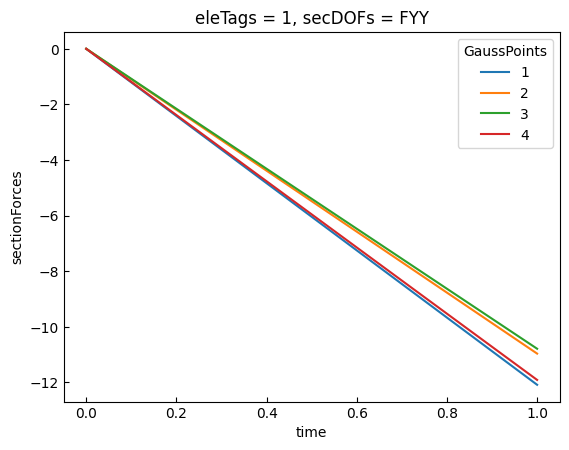

In [13]:
sec_forces_fxx = sec_forces.sel(
    eleTags=1,
    secDOFs="FYY",
)
# plot
sec_forces_fxx.plot.line(
    x="time",
)
plt.show()

### Stresses and Strains

Below, we retrieve the stress and strain data, which is a **five-dimensional** array.
The dimensions are, in order, **('time', 'eleTags', 'GaussPoints', 'fiberPoints', 'stressDOFs')**, and we can conveniently retrieve data based on these dimensions and their coordinates.

In [14]:
stresses = all_resp["Stresses"]
strains = all_resp["Strains"]
print(stresses)
print("=" * 100)
print(strains)
print("=" * 100)
print(stresses.dims)

<xarray.DataArray 'Stresses' (time: 11, eleTags: 100, GaussPoints: 4,
                              fiberPoints: 5, stressDOFs: 5)> Size: 440kB
array([[[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
            0.00000000e+00,  0.00000

In [15]:
stresses2 = stresses.sel(eleTags=1, stressDOFs="sigma22")
strains2 = strains.sel(eleTags=1, stressDOFs="sigma22")
gauss_points = stresses2.coords["GaussPoints"].data
fiber_points = stresses2.coords["fiberPoints"].data

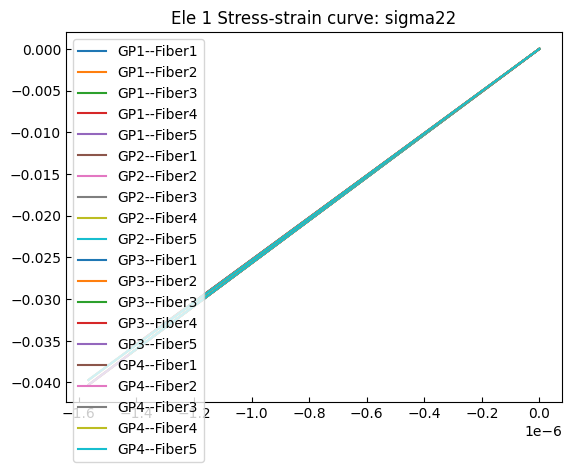

In [16]:
for gp_no in gauss_points:
    for fiber_no in fiber_points:
        s = stresses2.sel(GaussPoints=gp_no, fiberPoints=fiber_no)
        d = strains2.sel(GaussPoints=gp_no, fiberPoints=fiber_no)
        plt.plot(d, s, label=f"GP{gp_no}--Fiber{fiber_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.legend()
plt.show()

We can also compute averages along a specific dimension. For example, below, we calculate the average stress at the Gauss points:

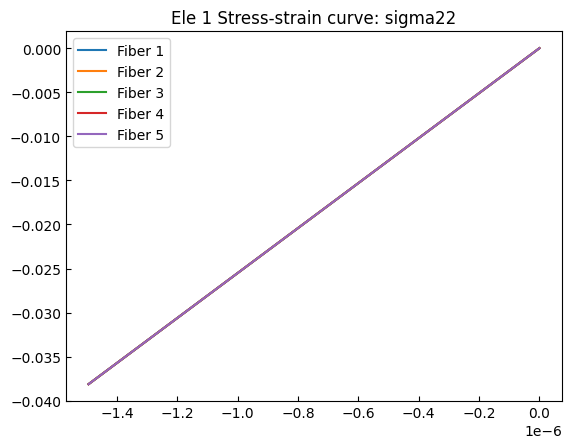

In [17]:
stresses3 = stresses2.mean(dim="GaussPoints")
strains3 = strains2.mean(dim="GaussPoints")

for fiber_no in fiber_points:
    s = stresses3.sel(fiberPoints=fiber_no)
    d = strains3.sel(fiberPoints=fiber_no)
    plt.plot(d, s, label=f"Fiber {fiber_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.legend()
plt.show()

In [18]:
stressesAtNodes = all_resp["StressesAtNodes"]
strainsAtNodes = all_resp["StrainsAtNodes"]

In [19]:
stressesAtNodes.sel(nodeTags=[1, 5, 10, 50], fiberPoints=5, stressDOFs="sigma22")

<xarray.DataArray 'StressesAtNodes' (time: 11, nodeTags: 4)> Size: 176B
array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.0040284 , -0.00349188, -0.00355105, -0.00351819],
       [-0.00805679, -0.00698375, -0.0071021 , -0.00703638],
       [-0.01208519, -0.01047563, -0.01065315, -0.01055458],
       [-0.01611358, -0.01396751, -0.01420421, -0.01407277],
       [-0.02014198, -0.01745939, -0.01775526, -0.01759096],
       [-0.02417038, -0.02095126, -0.02130631, -0.02110915],
       [-0.02819877, -0.02444314, -0.02485736, -0.02462734],
       [-0.03222717, -0.02793502, -0.02840841, -0.02814554],
       [-0.03625556, -0.0314269 , -0.03195946, -0.03166373],
       [-0.04028396, -0.03491877, -0.03551051, -0.03518192]],
      dtype=float32)
Coordinates:
  * time         (time) float32 44B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
  * nodeTags     (nodeTags) int64 32B 1 5 10 50
    fiberPoints  int64 8B 5
    stressDOFs   <U7 28B 'sigma22'